# 版本说明v4 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优

In [223]:
## 读取数据 #
#训练集的大小是(4320,27)，因为前三列分别是”日期“，”测站“和”测项“，实际大小为(4320,24)。  
#其中，4320又为(12,20,18)，分别对应”月份“，”日期“和”测项“。

import pandas as pd
import numpy as np

filepath_train = 'datas/train.csv' # 训练集的路径
filepath_test = 'datas/test.csv'   # 测试集的路径

data_train_orig = pd.read_csv(filepath_train,encoding='big5') # 读取训练集数据，台湾是用的big5码
data_test_orig = pd.read_csv(filepath_test,encoding='big5',
                          header=None,
                          index_col=0) # 读取测试集数据，没有列表，但是有index

test_options = data_train_orig.iloc[0:18,2].values                # 所有测项名称
test_option_index = {t:i for t,i in zip(test_options,range(18))}  # 测项的索引字典

data_train_orig = data_train_orig.iloc[:,3:] # 去掉前三列无用数据
data_train_orig[data_train_orig == 'NR'] = 0 # 设置雨量为NR的数据为0
data_train_orig = data_train_orig.to_numpy()

data_test_orig = data_test_orig.iloc[:,1:] # 去掉标识'测项'的第一列
data_test_orig[data_test_orig == 'NR'] = 0
data_test_numpy = data_test_orig.to_numpy()

# 转化每月数据 #
#把数据(12\*20\*18,24)转化成(12,18,24\*18)的数据格式，对应(月份，测项，小时*每月天数)

data_train_month = np.empty([12,18,24*20])  # 定义初始值

for month in range(12):
    for day in range(20):
        row_start = (month * 20 + day) * 18 # 起始行，每月20天，每天18个特征
        row_end = row_start + 18            # 每天18个特征
        data_day = data_train_orig[row_start:row_end,:]        # 获得数据切片
        
        col_start = day * 24                # 每天有24小时
        col_end = col_start + 24
        data_train_month[month,:,col_start:col_end] = data_day # 设置数据切片

# 生成样本数据 #
#因为是预测第十天的数据，所以连续九天的数据合并成一条数据,X_train_full的维度(12\*471,18\*9)

sample_number_month = 24 * 20 - 10 + 1                     # 计算每月的样本数

X_train_full = np.empty([sample_number_month * 12,18 * 9]) # 初始化训练集X
y_train_full = np.empty([sample_number_month * 12,])       # 初始化训练集y

for month in range(12):
    for sample in range(sample_number_month):
        col_start = sample           # 开始列
        col_end   = col_start + 9    # 取9列数据
        data_X = data_train_month[month,:,col_start:col_end].reshape(1,-1) # 变成一行数据
        data_y = data_train_month[month,test_option_index['PM2.5'],col_end] # y是下一列数据
        
        row = month * sample_number_month + sample # 插入数据的行号
        X_train_full[row,:] = data_X
        y_train_full[row] = data_y

test_number = data_test_numpy.shape[0] // 18
X_test = np.empty([test_number,18 * 9])
for sample in range(test_number):
    row_start = sample * 18
    row_end = row_start + 18
    X_test[sample] = data_test_numpy[row_start:row_end,:].reshape(1,-1)
    
X_train_pd = pd.DataFrame(X_train_full)
X_test_pd  = pd.DataFrame(X_test)

# 拆分训练集和验证集 #

In [224]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X_train_pd,
                                                   y_train_full,
                                                   test_size=0.2) # 分割验证集和验证集
n_features = X_train.shape[1]

# 建立pipeline #

## 定义选择测项的Transformer ##

In [226]:
from sklearn.base import BaseEstimator,TransformerMixin
class SelectTestOptionTransformer(BaseEstimator,TransformerMixin):
    
    def __init__(self,exclude=[],exclude_index=None):
        self.exclude = exclude
        self.exclude_index = exclude_index
        
    def fit(self,X,y=None):
        return self

    def transform(self,X,y =None):
        exclude = []
        
        if self.exclude_index:
            exclude = [self.exclude_index]

        elif self.exclude:
            exclude = [test_option_index[e] for e in self.exclude] # 获得测项对应的索引值
        
        X_copy = X.copy()                                   
        
        for e in exclude:
            X_copy.drop(columns=[9 * e + i for i in range(9)],inplace=True)                            
        return X_copy


SelectTestOptionTransformer(test_option_index.keys() - ['PM2.5']).transform(X_train_pd)
# SelectTestOptionTransformer().transform(X_test_pd)

,81,82,83,84,85,86,87,88,89
0,26.0,39.0,36.0,35.0,31.0,28.0,25.0,20.0,19.0
1,39.0,36.0,35.0,31.0,28.0,25.0,20.0,19.0,30.0
2,36.0,35.0,31.0,28.0,25.0,20.0,19.0,30.0,41.0
3,35.0,31.0,28.0,25.0,20.0,19.0,30.0,41.0,44.0
4,31.0,28.0,25.0,20.0,19.0,30.0,41.0,44.0,33.0
...,...,...,...,...,...,...,...,...,...
5647,8.0,10.0,4.0,1.0,1.0,7.0,24.0,37.0,49.0
5648,10.0,4.0,1.0,1.0,7.0,24.0,37.0,49.0,37.0
5649,4.0,1.0,1.0,7.0,24.0,37.0,49.0,37.0,28.0
5650,1.0,1.0,7.0,24.0,37.0,49.0,37.0,28.0,17.0


In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

exclude = [
    'CH4',
    'CO',
    'NMHC',
    'NO',
    'NO2',
    'NOx',
    'RAINFALL',
    'RH',
    'SO2',
    'THC',
    'WD_HR',
    'WIND_DIREC',
    'WIND_SPEED',
    'WS_HR'
]
options = SelectTestOptionTransformer(exclude)

model = LinearRegression()

pipeline = Pipeline(steps=[('options',options),
                           ('scaler', StandardScaler()),
                           ('model' , model)])

pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

训练集的RMSE:5.78681
验证集的RMSE:6.40383
验证集的score:0.86520


# 定义超参搜索的工具 #

## 定义画学习曲线函数 ##

In [157]:
import matplotlib.pyplot as plt

def plot_validation_curve(train_scores,valid_scores,param_range,ylim=(0.7,1)):
    plt.plot(param_range,train_scores.mean(axis=1),label='train scores') # 画训练集的分数
    
    valid_mean = valid_scores.mean(axis=1)
    plt.plot(param_range,valid_mean,label='valid scores')                # 画验证集的分数

    valid_max = valid_mean.max()                           # 验证集中的最大分数
    valid_argmax = param_range[valid_mean.argmax()]        # 验证集最大分数对应的参数取值
    plt.plot(valid_argmax,valid_max,'x',)                  # 画出最大参数的位置
    plt.text(valid_argmax,valid_max + 0.01,
             '({},{:.4f})'.format(valid_argmax,valid_max)) # 画出最大参数的坐标值

    plt.legend()
    plt.ylim(ylim)
    plt.show()
    
    return valid_argmax,valid_max # 返回最大得分和对应的参数值

## 定义搜索函数 ##

In [158]:
from sklearn.model_selection import validation_curve

def search(param,param_range,ylim=(0.7,1)):
    train_scores,valid_scores = validation_curve(pipeline,
                                                 X_train,
                                                 y_train,
                                                 param,
                                                 param_range,
                                                 verbose=1,
                                                 n_jobs=4,
                                                 error_score=0)
    param_max,score_max = plot_validation_curve(train_scores,valid_scores,param_range)
    return (param_max,score_max,train_scores,valid_scores)

## 定义方格搜索函数 ##

In [159]:
from sklearn.model_selection import GridSearchCV

def grid_search(gridparam):
    grid_search = GridSearchCV(pipeline,gridparam,verbose=1,n_jobs=4)

    history = grid_search.fit(X_train,y_train)

    print(history.best_params_)
    print(history.best_score_)
    
    return history

# 超参搜索 #

## 调参前训练score ##

In [166]:
from sklearn.model_selection import cross_val_score

score_base = cross_val_score(pipeline,X_train,y_train).mean() # 打印无调参时的score值
score_base

0.8695275608568004

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    5.7s finished


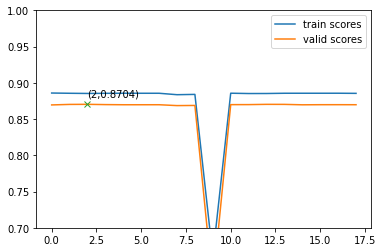

In [163]:
history = search('options__exclude_index',range(18))

In [201]:
scores_valid = history[3]
scores_mean_valid = scores_valid.mean(axis=1)
exclude = [test_options[i] for i,score in zip(range(18),scores_mean_valid)
                                            if score > score_base]
exclude

['CH4',
 'CO',
 'NMHC',
 'NO',
 'NO2',
 'NOx',
 'RAINFALL',
 'RH',
 'SO2',
 'THC',
 'WD_HR',
 'WIND_DIREC',
 'WIND_SPEED',
 'WS_HR']

In [193]:
test_option_index.keys() - exclude

{'AMB_TEMP', 'O3', 'PM10', 'PM2.5'}

## 只评估PM2.5 ##
**总结**：效果比所有的数据差

In [181]:
options.exclude = test_option_index.keys() - ['PM2.5'] # 从所有测项中删除PM2.5

cross_val_score(pipeline,X_train,y_train).mean()

0.8653195076141778

# 去掉噪音 #
**总结**：准确率提升

In [202]:
options.exclude = exclude
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

0.8711557785661759

In [199]:
options.exclude = exclude
options.exclude.append('O3')
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

0.8710513304193649

去掉一些气体

In [195]:
options.exclude = ['CH4','CO','NO','NO2','SO2','O3']
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

0.8706334274851468

# 训练模型 #

In [203]:
options.exclude = exclude
options.exclude_index = None

pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

训练集的RMSE:5.78681
验证集的RMSE:6.40383
验证集的score:0.86520


# 输出数据 #

In [204]:
pipeline.fit(X_train_pd,y_train_full)

preds_train_full = pipeline.predict(X_train_pd)
print('训练集的RMSE:{:.5f}'.format(mean_squared_error(preds_train_full,y_train_full)**0.5))

preds_test = pipeline.predict(X_test_pd)
ids = ['id_' + str(i) for i in range(len(X_test_pd))]
output = pd.DataFrame({'id':ids,
                       'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)

训练集的RMSE:5.90654
